CoverType is a dataset with forest cartographic variables, this is a multiclassification tabular job.

## Set Constants

In [8]:
PROJECT_ID = 'jchavezar-demo'
REGION = 'us-central1'
DIR = 'xgboost_custom'
BQ_TABLE_DIR = 'vertex_datasets_public.cover_type_4Mrows'
MODEL_URI = 'gs://vtx-models/xgboost/cover_type'
STAGING_URI = 'gs://vtx-staging/xgboost/cover_type'
TRAIN_IMAGE_URI = 'us-central1-docker.pkg.dev/jchavezar-demo/trainings/xgboost-dask-gpu:latest'
PREDICTION_IMAGE_URI = 'us-central1-docker.pkg.dev/jchavezar-demo/custom-predictions/xgboost-dask-cpu:latest'

## Import Libraries

In [15]:
from google.cloud import aiplatform as aip

## Create Folder Structure

```
xgboost_custom
  |  Dockerfile
  └─── trainer
     |  train.py
     |

```

In [50]:
!rm -fr $DIR
!mkdir $DIR
!mkdir $DIR/trainer

## Train Code

In [57]:
%%writefile $DIR/trainer/train.py
import os
import json
import dask
import argparse
import subprocess
import dask_bigquery
import xgboost as xgb
from google.cloud import storage
from xgboost import dask as dxgb
from dask.distributed import Client
from dask_cuda import LocalCUDACluster
import warnings
warnings.filterwarnings(action="ignore")

class Training:
    def __init__(self, project, bq_table_dir, num_workers, threads_per_worker):
        self.project = project
        self.bq_table_dir = bq_table_dir
        self.num_workers = num_workers
        self.threads_per_worker = threads_per_worker
        
        print(self.threads_per_worker)
    
    def load_data(self):
        '''Load data from BigQuery to Dask'''
        _ = self.bq_table_dir.split('.')
    
        ddf = dask_bigquery.read_gbq(
            project_id='jchavezar-demo',
            dataset_id=_[0],
            table_id=_[1]
        ).dropna()
        
        print(f"[INFO] ------ Splitting dataset")
        df_train, df_eval = ddf.random_split([0.8, 0.2], random_state=123)
        self.df_train_features = df_train.drop('Cover_Type', axis=1)
        self.df_eval_features = df_eval.drop('Cover_Type', axis=1)
        self.df_train_labels = df_train.pop('Cover_Type')
        self.df_eval_labels = df_eval.pop('Cover_Type')
    
    def model_train(self):
        print("[INFO] ------ Creating dask cluster")
        scheduler_ip = subprocess.check_output(['hostname','--all-ip-addresses'])
        scheduler_ip = scheduler_ip.decode('UTF-8').split()[0]
        
        with LocalCUDACluster(
            ip=scheduler_ip,
            n_workers=self.num_workers, 
            threads_per_worker=self.threads_per_worker
        ) as cluster:
            with Client(cluster) as client:
                print('[INFO]: ------ Calling main function ')

                print("[INFO]: ------ Dataset for dask")
                dtrain = dxgb.DaskDeviceQuantileDMatrix(client, self.df_train_features, self.df_train_labels)
                dvalid = dxgb.DaskDeviceQuantileDMatrix(client, self.df_eval_features, self.df_eval_labels)

                print("[INFO]: ------ Training...")
                output = xgb.dask.train(
                    client,
                    {
                        "verbosity": 2, 
                        "tree_method": "gpu_hist", 
                        "objective": "multi:softprob",
                        "eval_metric": ["mlogloss"],
                        "learning_rate": 0.1,
                        "gamma": 0.9,
                        "subsample": 0.5,
                        "max_depth": 9,
                        "num_class": 8
                    },
                    dtrain,
                    num_boost_round=10,
                    evals=[(dvalid, "valid1")],
                    early_stopping_rounds=5
                )
                model = output["booster"]
                best_model = model[: model.best_iteration]
                print(f"[INFO] ------ Best model: {best_model}")
                best_model.save_model("/tmp/model.json")
                model_metrics = output["history"]["valid1"]
                with open("/tmp/metadata.json", "w") as outfile:
                    json.dump(model_metrics, outfile)
    
    def storage_artifacts(self):        
        print('[INFO] ------ Storing Artifacts on Google Cloud Storage')
        bucket = os.environ['AIP_MODEL_DIR'].split('/')[2]
        blob_name = '/'.join(os.environ['AIP_MODEL_DIR'].split('/')[3:])
        bucket ='vtx-models'
        storage_client = storage.Client(project=self.project)
        bucket = storage_client.bucket(bucket)

        for i in ["model.json", "metadata.json"]:
            blob = bucket.blob(f'{blob_name}{i}')
            blob.upload_from_filename(f'/tmp/{i}')        
            
if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--project',
        type = str,
        default = os.environ['CLOUD_ML_PROJECT_ID'],
        help = 'This is the tenant or the Google Cloud project id name'
    )
    parser.add_argument(
        "--bq_table_dir",
        type = str,
        help = "BigQuery Dataset URI in the format [DATASET].[TABLE]"
    )
    parser.add_argument(
        '--num_workers', type=int, help='num of workers',
        default=1
    )
    parser.add_argument(
        '--threads_per_worker', type=int, help='num of threads per worker',
        default=1
    )
    
    args = parser.parse_args()
    training = Training(args.project, args.bq_table_dir, args.num_workers, args.threads_per_worker)
    training.load_data()
    training.model_train()
    training.storage_artifacts()

Overwriting xgboost_custom/trainer/train.py


## Dockerfile

In [63]:
%%writefile $DIR/Dockerfile
FROM rapidsai/rapidsai-nightly:22.12-cuda11.2-base-ubuntu20.04-py3.8

RUN pip install google-cloud-storage \
  && pip install gcsfs \
  && pip install pandas \
  && pip install dask-bigquery

COPY trainer trainer/

ENTRYPOINT ["python", "trainer/train.py"]

Overwriting xgboost_custom/Dockerfile


## Crete Image and Push it to Google Artifacts Repository

In [64]:
!docker build -t $TRAIN_IMAGE_URI $DIR/.

Sending build context to Docker daemon  8.192kB
Step 1/4 : FROM rapidsai/rapidsai-nightly:22.12-cuda11.2-base-ubuntu20.04-py3.8
 ---> fbadf85eb205
Step 2/4 : RUN pip install google-cloud-storage   && pip install gcsfs   && pip install pandas   && pip install dask-bigquery
 ---> Using cache
 ---> c82daf08c0ca
Step 3/4 : COPY trainer trainer/
 ---> Using cache
 ---> a5237904f16c
Step 4/4 : ENTRYPOINT ["python", "trainer/train.py"]
 ---> Using cache
 ---> 3b3cf1bbc944
Successfully built 3b3cf1bbc944
Successfully tagged us-central1-docker.pkg.dev/jchavezar-demo/trainings/xgboost-dask-gpu:latest


In [65]:
!docker push $TRAIN_IMAGE_URI

The push refers to repository [us-central1-docker.pkg.dev/jchavezar-demo/trainings/xgboost-dask-gpu]

bc99c6c2: Preparing 
7871a528: Preparing 
10f8ab46: Preparing 
a60296d0: Preparing 
04ce2dbe: Preparing 
8d70af49: Preparing 
57cc060a: Preparing 
f22f7d2b: Preparing 
e8b67dbb: Preparing 
4e28b8f7: Preparing 
fdd7be17: Preparing 
070c6f18: Preparing 
070c6f18: Layer already exists latest: digest: sha256:6119cc007aa3c4b07dca7f93c27222ef027a87deb6b4f6bdf856433e3f94a5e9 size: 3064


## Create Vertex Training from Code [CustomJob]

In [ ]:
aip.init(
    project=PROJECT_ID,
    location=REGION)

num_gpus = 4

worker_pool_specs = [
    {
        "machine_spec": {
            "machine_type": "n1-standard-4",
            "accelerator_type": "NVIDIA_TESLA_V100",
            "accelerator_count": num_gpus
        },
        "replica_count": "1",
        "container_spec": {
            "image_uri": TRAIN_IMAGE_URI,
            "args": [
                "--bq_table_dir", "vertex_datasets_public.cover_type_4Mrows",
                "--num_workers", f"{num_gpus}",
                "--threads_per_worker", "4" 
            ]
        }
    },
    ]

job = aip.CustomJob(
    display_name = '05cb-bqdask-xgboost-customjob',
    worker_pool_specs = worker_pool_specs,
    base_output_dir = MODEL_URI,
    staging_bucket = STAGING_URI
)

model = job.run(
)

Creating CustomJob
CustomJob created. Resource name: projects/569083142710/locations/us-central1/customJobs/1439934858825564160
To use this CustomJob in another session:
custom_job = aiplatform.CustomJob.get('projects/569083142710/locations/us-central1/customJobs/1439934858825564160')
View Custom Job:
https://console.cloud.google.com/ai/platform/locations/us-central1/training/1439934858825564160?project=569083142710
CustomJob projects/569083142710/locations/us-central1/customJobs/1439934858825564160 current state:
JobState.JOB_STATE_PENDING
CustomJob projects/569083142710/locations/us-central1/customJobs/1439934858825564160 current state:
JobState.JOB_STATE_PENDING


## Training Loss Chart

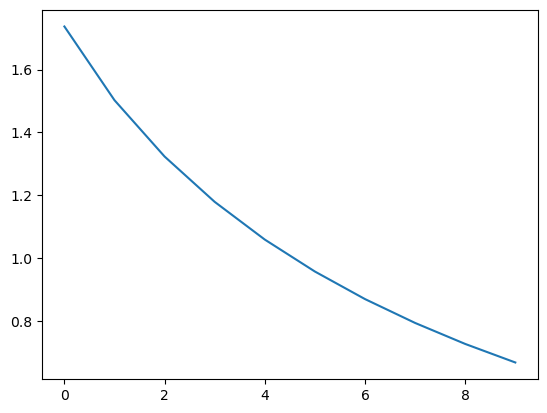

In [4]:
import json
import matplotlib.pyplot as plt
from google.cloud import storage
from google.cloud import storage

client = storage.Client()
bucket = client.get_bucket('vtx-models')
blob = bucket.blob('xgboost/cover_type/model/metadata.json')
blob.download_to_filename('metadata.json')

# Opening JSON file
with open('metadata.json') as json_file:
    data = json.load(json_file)

plt.plot(data['mlogloss'])
plt.show()

## Upload Model

### Prediction Code

In [9]:
!rm -fr $DIR/prediction
!mkdir $DIR/prediction

### Prediction Code

In [10]:
%%writefile $DIR/prediction/app.py

import os
import logging
import pandas as pd
import xgboost as xgb
from flask import Flask, request, Response, jsonify
from google.cloud import storage

client = storage.Client(project=os.environ['PROJECT_ID'])

# Model Download from gcs

fname = "model.json"

with open(fname, "wb") as model:
    client.download_blob_to_file(
        f"{os.environ['AIP_STORAGE_URI']}/{fname}", model
    )

# Loading model
print("[INFO] ------ Loading model from: {}".format(fname))
model = xgb.Booster(model_file=fname)

# Creation of the Flask app
app = Flask(__name__)

# Flask route for Liveness checks
@app.route(os.environ['AIP_HEALTH_ROUTE'])
def isalive():
    status_code = Response(status=200)
    return status_code

# Flask route for predictions
@app.route(os.environ['AIP_PREDICT_ROUTE'],methods=['GET','POST'])
def prediction():
    _features = ['Id','Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                          'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm','Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3', 
                          'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9',
                          'Soil_Type10','Soil_Type11','Soil_Type12','Soil_Type13','Soil_Type14','Soil_Type15','Soil_Type16','Soil_Type17','Soil_Type18','Soil_Type19', 
                          'Soil_Type20', 'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28', 'Soil_Type29',
                          'Soil_Type30', 'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40']
    data = request.get_json(silent=True, force=True)
    dmf = xgb.DMatrix(pd.DataFrame(data["instances"], columns=_features))
    response = pd.DataFrame(model.predict(dmf))
    logging.info(f"Response: {response}")
    return jsonify({"Cover Type": str(response.idxmax(axis=1)[0])})

if __name__ == "__main__":
    app.run(debug=True, host='0.0.0.0', port=8080)

Writing xgboost_custom/prediction/app.py


In [11]:
%%writefile $DIR/prediction/requirements.txt

google-cloud-storage
numpy
pandas
flask
xgboost

Writing xgboost_custom/prediction/requirements.txt


In [12]:
%%writefile $DIR/prediction/Dockerfile

FROM python:3.7-buster

RUN mkdir my-model

COPY app.py ./app.py
COPY requirements.txt ./requirements.txt
RUN pip install -r requirements.txt 

# Flask Env Variable
ENV FLASK_APP=app

# Expose port 8080
EXPOSE 8080

CMD flask run --host=0.0.0.0 --port=8080

Writing xgboost_custom/prediction/Dockerfile


## Building and Pushing Prediction Image

In [13]:
!gcloud builds submit --tag $PREDICTION_IMAGE_URI $DIR/prediction/. --timeout 3000

Creating temporary tarball archive of 3 file(s) totalling 2.5 KiB before compression.
Uploading tarball of [xgboost_custom/prediction/.] to [gs://jchavezar-demo_cloudbuild/source/1674102596.535233-8794cf1a4d4c49ba8615838043463da3.tgz]
Created [https://cloudbuild.googleapis.com/v1/projects/jchavezar-demo/locations/global/builds/7326dd73-b512-4ef1-954c-ed874336e923].
Logs are available at [ https://console.cloud.google.com/cloud-build/builds/7326dd73-b512-4ef1-954c-ed874336e923?project=569083142710 ].
----------------------------- REMOTE BUILD OUTPUT ------------------------------
starting build "7326dd73-b512-4ef1-954c-ed874336e923"

FETCHSOURCE
Fetching storage object: gs://jchavezar-demo_cloudbuild/source/1674102596.535233-8794cf1a4d4c49ba8615838043463da3.tgz#1674102596745717
Copying gs://jchavezar-demo_cloudbuild/source/1674102596.535233-8794cf1a4d4c49ba8615838043463da3.tgz#1674102596745717...
/ [1 files][  1.4 KiB/  1.4 KiB]                                                
Operation 

In [25]:
model = aip.Model.upload(
    display_name = '05-cb-cover_type',
    serving_container_image_uri = PREDICTION_IMAGE_URI,
    artifact_uri = f'{MODEL_URI}/model',
    serving_container_environment_variables = {
        'PROJECT_ID': PROJECT_ID,
    }
)

Creating Model
Create Model backing LRO: projects/569083142710/locations/us-central1/models/7767550471958429696/operations/6053111471422832640
Model created. Resource name: projects/569083142710/locations/us-central1/models/7767550471958429696@1
To use this Model in another session:
model = aiplatform.Model('projects/569083142710/locations/us-central1/models/7767550471958429696@1')


In [26]:
endpoint = model.deploy(
    deployed_model_display_name = '05-cb-cover_ep_dep',
    traffic_percentage = 100,
    machine_type = 'n1-standard-4',
    min_replica_count = 1,
    max_replica_count = 1,
)

Creating Endpoint
Create Endpoint backing LRO: projects/569083142710/locations/us-central1/endpoints/4545878048481738752/operations/517765316919427072
Endpoint created. Resource name: projects/569083142710/locations/us-central1/endpoints/4545878048481738752
To use this Endpoint in another session:
endpoint = aiplatform.Endpoint('projects/569083142710/locations/us-central1/endpoints/4545878048481738752')
Deploying model to Endpoint : projects/569083142710/locations/us-central1/endpoints/4545878048481738752
Deploy Endpoint model backing LRO: projects/569083142710/locations/us-central1/endpoints/4545878048481738752/operations/5740814984762359808
Endpoint model deployed. Resource name: projects/569083142710/locations/us-central1/endpoints/4545878048481738752
